In [81]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from torch.optim import Adam
from torchvision import models
from torch.autograd import Variable
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from sys import path
from zipfile import ZipFile

from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F

import pydicom

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [82]:
PATH = "./data/unifesp-x-ray-body-part-classifier.zip"

from pathlib import Path

data_path = Path(PATH)
if not (data_path).exists():
    print("-- un-zip datasets --")
    with ZipFile(PATH, 'r') as zip_ref:
        zip_ref.extractall('./data')
else:
    print("data exists")

data exists


[[24307 23872 23814 ... 24294 24420 24180]
 [22436 22232 22228 ... 24529 24283 24447]
 [22568 22700 22944 ... 24453 24432 24459]
 ...
 [24951 24959 25010 ... 24550 24571 24598]
 [24931 24929 24930 ... 24531 24478 24611]
 [25004 24909 24951 ... 24672 24503 24549]]


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.8/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (15-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


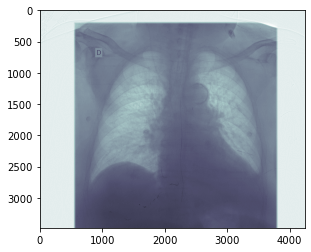

In [83]:
TRAIN_PATH  = './data/train/train/'
TEST_PATH = './data/test/test/'

dcm = pydicom.dcmread('./data/train/train/1/1.2.826.0.1.3680043.8.498.89102450329340531816015855773961083133/1.2.826.0.1.3680043.8.498.11278653404499913987623237519434199794/1.2.826.0.1.3680043.8.498.65452424240994805812717428674475343109-c.dcm')
img1 = dcm.pixel_array
print(img1)
plt.imshow(img1, cmap=plt.cm.bone)

In [84]:
import glob

train_dcms = glob.glob(TRAIN_PATH + '*/*/*/*.dcm')

In [98]:
class CustomSet(Dataset):
    def __init__(self, dcms, dataframe, path, mode, transforms):
        self.dcms = dcms
        self.dataframe = dataframe
        self.mode = mode
        self.transforms = transforms
        self.path = path
        
    def __len__(self):
        return len(self.dcms)
    
    def __getitem__(self, idx):
        dcm = pydicom.dcmread(self.dcms[idx])
        a = self.dcm_normalization(dcm)
        a = np.vstack(a).astype(np.float)
        img = torch.from_numpy(a)
        uid = self.dcms[idx].split('/')[7][:-6]
        target_row = self.dataframe.loc[(self.dataframe["SOPInstanceUID"] == uid)]
        label = int(target_row['Target'].values[0].split(' ')[0])
        return img, label

    def dcm_normalization(self, dcm):
        img = dcm.pixel_array.astype(np.float32)
        img = (img / (2 ** dcm.BitsStored))
        return img

21


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.8/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (15-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/var/folders/jg/5vxry5r963zgtgwt391zcvxc0000gn/T/ipykernel_25850/3108057437.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.vstack(a).astype(np.float)


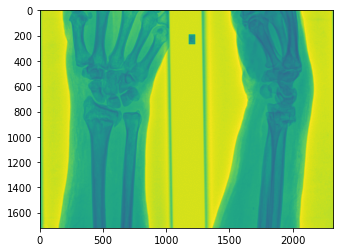

In [99]:
train_transforms = transforms.Compose([
    transforms.Resize((360 , 360)) ,
])

df = pd.read_csv('./data/train.csv')
check = CustomSet(train_dcms , df, TRAIN_PATH , "train" , train_transforms)
img, label = check[100]
print(label)
plt.imshow(img)

In [79]:
BATCH_SIZE = 20

train = DataLoader(CustomSet(train_dcms , df, TRAIN_PATH , "train" , train_transforms), batch_size=BATCH_SIZE , shuffle = True)

In [80]:
feature, label = next(iter(train))


/opt/homebrew/Caskroom/miniforge/base/envs/kaggle/lib/python3.8/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (15-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/var/folders/jg/5vxry5r963zgtgwt391zcvxc0000gn/T/ipykernel_25850/1242553130.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.vstack(a).astype(np.float)


RuntimeError: stack expects each tensor to be equal size, but got [2920, 2320] at entry 0 and [3480, 4240] at entry 1